## ЦЕЛИ ПРОЕКТА

Создатели quiz-игры хотят выяснить, как меняется поведения пользователей в зависиииости от факта прохождения обучения приложении и количества таких прохождений

Перед нами стоит три цели:


    - Проверить, отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение. 

    - Посмотреть, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 

    - Дополнительная задача. Как часто пользователи начинают обучение после того, как они выбрали уровень сложности? 

Кроме того, необходимо представить визуалицаию полученных ответов.

### Проведем подготовку данных

In [1]:
#Загрузим все необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Загрузим файлы с данными
# events_df = pd.read_csv('D:\Мои Файлы\Работать\Events.csv')
# purchase_df = pd.read_csv('D:\Мои Файлы\Работать\purchase.csv')

events_df = pd.read_csv('7_4_Events.csv')
purchase_df = pd.read_csv('purchase.csv')

In [3]:
# Создадим датафрейм для игроков, зарегистрировавшихся в 2018 году
reg_2018 = (events_df.start_time>='2018-01-01')&(events_df.start_time<'2019-01-01')&(events_df.event_type=='registration')
registered18 = events_df[reg_2018].user_id.to_list() 
events18 = events_df[events_df.user_id.isin(registered18)].copy()
# Таким же образом создадим датафрейм для сделавших покупки в 2018 году
purchase18 = purchase_df[purchase_df.user_id.isin(registered18)].copy()
# Отформатируем даты в этих датафрeймах
events18.start_time = pd.to_datetime(events18.start_time, format='%Y-%m-%dT%H:%M:%S')
purchase18.event_datetime = pd.to_datetime(purchase18.event_datetime, format='%Y-%m-%dT%H:%M:%S')
# Переиминeем колонки
events18 = events18.rename(columns = {'id': 'event_id'})
purchase18 = purchase18.rename(columns = {'id':'purchase_id', 'event_datetime':'start_time'})
purchase18['event_type'] = 'purchase'
# Объединим датафреймы
total_events18 = pd.concat([events18, purchase18], ignore_index=True)

In [4]:
#Создадим группы пользователей по пройденным этапам
registered_users = events18[events18['event_type'] == 'registration']['user_id'].nunique()
tutorial_started_users = events18[events18['event_type'] == 'tutorial_start']['user_id'].nunique()
tutorial_finish_users = events18[events18['event_type'] == 'tutorial_finish']['user_id'].nunique()
tutorial_not_started_users = registered_users - tutorial_started_users
level_choice_users = events18[events18['event_type'] == 'level_choice']['user_id'].nunique()
pack_choice_users = events18[events18['event_type'] == 'pack_choice']['user_id'].nunique()
purchase_users = purchase18['user_id'].nunique()

### Задача №1
Перейдем к выполнению первого задания и проверим, отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение.

In [5]:
#Организуем сводную таблицу на основе датафрейма
pivot = total_events18.pivot_table(values =['start_time'], index = ['user_id'],
                      columns = ['event_type'],
                      aggfunc = 'min')
pivot.head()



start_time                               \
event_type        level_choice         pack_choice purchase   
user_id                                                       
27832                      NaT                 NaT      NaT   
27833                      NaT                 NaT      NaT   
27834                      NaT                 NaT      NaT   
27835      2018-01-01 20:37:22 2018-01-01 20:38:43      NaT   
27836                      NaT                 NaT      NaT   

                                                                        
event_type        registration     tutorial_finish      tutorial_start  
user_id                                                                 
27832      2018-01-01 03:48:40                 NaT                 NaT  
27833      2018-01-01 04:07:25 2018-01-01 17:50:08 2018-01-01 17:47:40  
27834      2018-01-01 08:35:10 2018-01-01 19:48:01 2018-01-01 19:46:11  
27835      2018-01-01 11:54:47 2018-01-01 15:06:15 2018-01-01 15:00:51  
27836      2018-01-01 13:28:07 2018-01-01 15:42:58 2018-01-01 14:54:40

In [6]:
#Сбросим двойную индескацию и сделаем user_id отдельной колонкой
pivot.columns=list(map('_'.join,pivot))
flattened_df = pivot.reset_index()

In [7]:
#Введем в таблицу колонки с временными промежутками между событиями
flattened_df['tmdlt Reg - LevCh'] = flattened_df['start_time_level_choice'] - flattened_df['start_time_registration']
flattened_df['tmdlt Reg - PackCh'] = flattened_df['start_time_pack_choice'] - flattened_df['start_time_registration']
flattened_df['tmdlt LevCh - PackCh'] = flattened_df['start_time_pack_choice'] - flattened_df['start_time_level_choice']
flattened_df['tmdlt LevCh - Pur'] = flattened_df['start_time_purchase'] - flattened_df['start_time_level_choice']
flattened_df['tmdlt PackCh - Pur'] = flattened_df['start_time_purchase'] - flattened_df['start_time_pack_choice']
flattened_df['tmdlt Reg - Pur'] = flattened_df['start_time_purchase'] - flattened_df['start_time_registration']

In [8]:
#Выделим из общего датафрейма такой, которой касался бы только игроков, закончивших обучение
tutorial_finish_users_1 = events18[events18['event_type'] == 'tutorial_finish']['user_id'].unique()
tutorial_finished = flattened_df[flattened_df.user_id.isin(tutorial_finish_users_1)]


In [9]:
#Сделаем то же для тех игроков, кто не ничинал обучение
tutorial_started_users_1 = set(events18[events18['event_type'] == 'tutorial_start']['user_id'])
registered_users_1 = set(events18[events18['event_type'] == 'registration']['user_id'])
tutorial_not_started_users = registered_users_1 - tutorial_started_users_1

tutorial_not_started = flattened_df[flattened_df.user_id.isin(tutorial_not_started_users)]

In [10]:
#Для обеих групп пользователей выясним среднее время между различными этапами, переведя его в удобный формат
f_Reg_LevCh = (tutorial_finished['tmdlt Reg - LevCh']/pd.Timedelta('1 hour')).mean()
f_Reg_PackCh = (tutorial_finished['tmdlt Reg - PackCh']/pd.Timedelta('1 hour')).mean()
f_LevCh_PackCh = (tutorial_finished['tmdlt LevCh - PackCh']/pd.Timedelta('1 minute')).mean()
f_LevCh_Pur = (tutorial_finished['tmdlt LevCh - Pur']/pd.Timedelta('1 hour')).mean()
f_PackCh_Pur = (tutorial_finished['tmdlt PackCh - Pur']/pd.Timedelta('1 hour')).mean()
f_Reg_Pur = (tutorial_finished['tmdlt Reg - Pur']/pd.Timedelta('1 hour')).mean()

n_Reg_LevCh = (tutorial_not_started['tmdlt Reg - LevCh']/pd.Timedelta('1 hour')).mean()
n_Reg_PackCh = (tutorial_not_started['tmdlt Reg - PackCh']/pd.Timedelta('1 hour')).mean()
n_LevCh_PackCh = (tutorial_not_started['tmdlt LevCh - PackCh']/pd.Timedelta('1 minute')).mean()
n_LevCh_Pur = (tutorial_not_started['tmdlt LevCh - Pur']/pd.Timedelta('1 hour')).mean()
n_PackCh_Pur = (tutorial_not_started['tmdlt PackCh - Pur']/pd.Timedelta('1 hour')).mean()
n_Reg_Pur = (tutorial_not_started['tmdlt Reg - Pur']/pd.Timedelta('1 hour')).mean()

In [11]:
#Объединим полученные значения в новый датафрейм, который нам понадобится для визуализации
means_merge= pd.DataFrame({'user_type': ['not_started', 'finished'],'Reg_LevCh':[n_Reg_LevCh, f_Reg_LevCh],
                            'Reg_PackCh':[n_Reg_PackCh, f_Reg_PackCh], 'LevCh_PackCh':[n_LevCh_PackCh, f_LevCh_PackCh],
                            'LevCh_Pur':[n_LevCh_Pur, f_LevCh_Pur],'PackCh_Pur':[n_PackCh_Pur,f_PackCh_Pur],'Reg_Pur':[n_Reg_Pur,f_Reg_Pur]})
means_merge

,user_type,Reg_LevCh,Reg_PackCh,LevCh_PackCh,LevCh_Pur,PackCh_Pur,Reg_Pur
0,not_started,5.259201,5.121160,5.397072,100.915631,100.825997,105.100530
1,finished,7.093571,7.176572,5.302434,89.390265,89.299900,96.500902


<AxesSubplot:xlabel='user_type', ylabel='Reg_LevCh'>

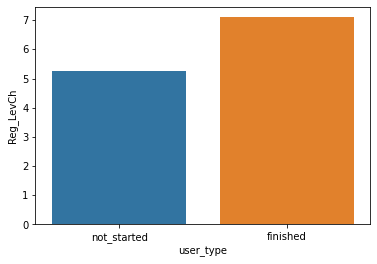

In [12]:
#Проведем визуалицацию полученных данных
#Начнем со времени между регистрацией и выбором уровня сложности
sns.barplot(x = 'user_type', y = 'Reg_LevCh', data = means_merge)

<AxesSubplot:xlabel='user_type', ylabel='Reg_PackCh'>

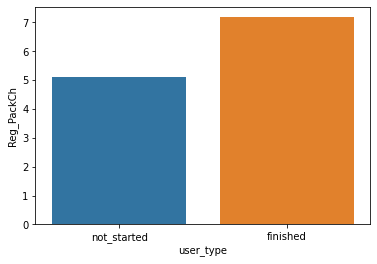

In [13]:
#Промежуток между регистрацией и выбором пакета вопросов
sns.barplot(x = 'user_type', y = 'Reg_PackCh', data = means_merge)

<AxesSubplot:xlabel='user_type', ylabel='LevCh_PackCh'>

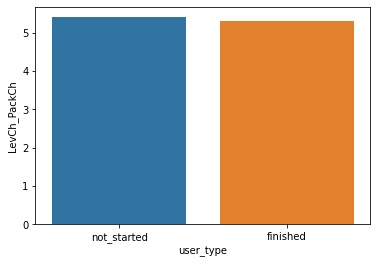

In [14]:
#Выбор уровня сложности и выбор пакета вопросов
sns.barplot(x = 'user_type', y = 'LevCh_PackCh', data = means_merge)

<AxesSubplot:xlabel='user_type', ylabel='LevCh_Pur'>

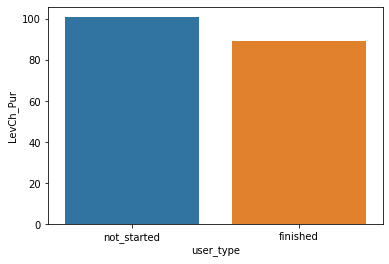

In [15]:
#Время между выбором уровня сложности и покупкой
sns.barplot(x = 'user_type', y = 'LevCh_Pur', data = means_merge)

<AxesSubplot:xlabel='user_type', ylabel='PackCh_Pur'>

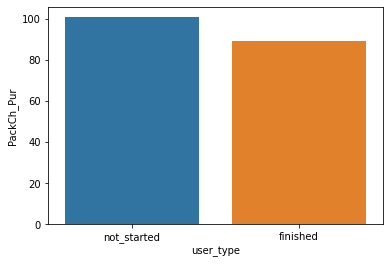

In [16]:
#Промежуток между выбором пакета вопросов и покупкой
sns.barplot(x = 'user_type', y = 'PackCh_Pur', data = means_merge)

<AxesSubplot:xlabel='user_type', ylabel='Reg_Pur'>

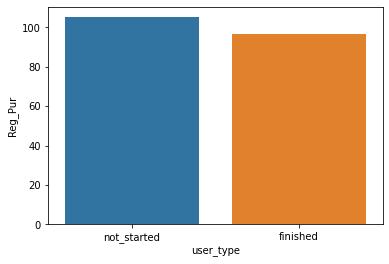

In [17]:
#Время между регистрацией и покупкой
sns.barplot(x = 'user_type', y = 'Reg_Pur', data = means_merge)

**Вывод №1**

В ходе анализа удалось установить, прошедшие обучение пользователи совершают покупки в приложении быстрее. В среднем для таких игроков время между регисрацией, выбором уровня сложности или выбором пакета бесплатных вопросов, с одной стороны, и покупкой, с другой, **короче на 10,5 часов**, чем для не проходивших обучение игроков. 

### Задача №2
Перейдем ко второму заданию и проверим, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь

In [18]:
#Создадим датафреймы, отражающие события окончания обучения и совершения покупки для отдельных игроков
users_count_tut=total_events18.groupby(['user_id'])['event_type'].apply(lambda x: (x=='tutorial_finish').sum()).reset_index()
users_count_purch=total_events18.groupby(['user_id'])['event_type'].apply(lambda x: (x=='purchase').sum()).reset_index()
#Объединим датафреймы
tut_purch_merged=users_count_tut.merge(users_count_purch, on='user_id',how='left')
#Переиминуем столбцы
tut_purch_merged=tut_purch_merged.rename(columns={'event_type_x':'num_tut_fin', 'user_id':'user_qtty','event_type_y':'purchase_qtty'})
#Сгруппируем данные по признаку количества законченных обучений на одного пользоваеля
tut_purch_group=tut_purch_merged.groupby(['num_tut_fin']).agg({'user_qtty':'count','purchase_qtty':'sum'}).reset_index()
#Введем в датафрейм еще один стоблец, отражащий долю сделавших покупку игровок относительно всех пользователей, прошедщих обучение то или иное количество раз
tut_purch_group['purchase_percentage'] = tut_purch_group['purchase_qtty']/tut_purch_group['user_qtty']*100
tut_purch_group.round({'purchase_percentage':1})

,num_tut_fin,user_qtty,purchase_qtty,purchase_percentage
0,0,9676,153,1.6
1,1,8015,1143,14.3
2,2,1321,182,13.8
3,3,345,44,12.8
4,4,178,19,10.7
5,5,117,19,16.2
6,6,101,15,14.9
7,7,97,15,15.5
8,8,54,6,11.1
9,9,22,4,18.2


Text(0.5, 0, 'Количество обучений')

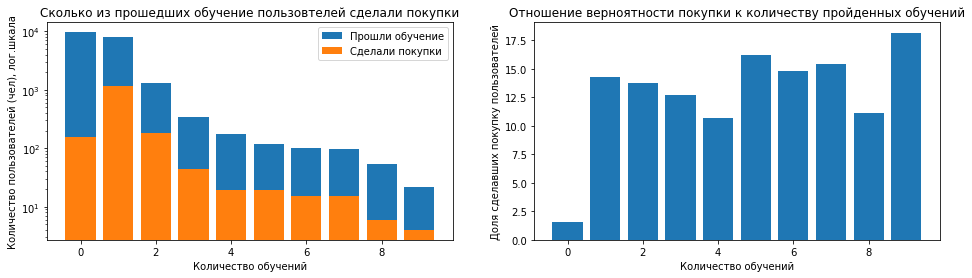

In [19]:
#Визуализируем полученные данные с помощью столбиковых диаграмм
fig, axes = plt.subplots(1, 2, figsize=(16,4))


axes[0].bar(x = tut_purch_group['num_tut_fin'], height = tut_purch_group['user_qtty'],log=True, label = 'Прошли обучение')
axes[0].bar(x = tut_purch_group['num_tut_fin'], height = tut_purch_group['purchase_qtty'], label = 'Сделали покупки')
axes[0].set_title('Сколько из прошедших обучение пользовтелей сделали покупки')
axes[0].set_ylabel('Количество пользователей (чел), лог.шкала')
axes[0].set_xlabel('Количество обучений')
axes[0].legend(loc = 1)

axes[1].bar(x = tut_purch_group['num_tut_fin'], height = tut_purch_group['purchase_percentage'])
axes[1].set_title('Отношение верноятности покупки к количеству пройденных обучений')
axes[1].set_ylabel('Доля сделавших покупку пользователей')
axes[1].set_xlabel('Количество обучений')

**Вывод №2:**

Требовалось доказать, что "успешное обучение само по себе влияет на оплату, и без разницы, каким этапом оно шло". Проведенный анализ показал, что независимо от количества пройденных обучений сам факт его прохождения значительно увевличивает вероятность совершения игроком покупки в приложении: от **1,6%** для тех, кто не завершил обучения, до как минимум **10,7%** (прошедшие обучение 4 раза). В среднем, такие игроки совершают покупку в **14,2%** случаев.

### Задача №3
Перейдем к дополнительной задаче и узнаем, как часто пользователи начинают обучение после того, как они выбрали уровень сложности.

In [20]:
#Выделим пользователей, выбравших уровень сложности игры, и создадим для них датафрейм
level_choice_users = set(total_events18[total_events18['event_type']=='level_choice']['user_id'])
lc_df = total_events18[total_events18['user_id'].isin(level_choice_users)]

#Далее преобразуем его, оставив только время выбора уровня сложности и время начала обучения
level = lc_df[lc_df['event_type'] == 'level_choice']
level = level[['user_id', 'start_time']].rename(columns={'start_time':'level_choice_time'})

tuto_st = lc_df[lc_df['event_type'] == 'tutorial_start']
tuto_st = tuto_st[['user_id', 'start_time']].rename(columns={'start_time':'tutorial_start_time'})

tuto_level_merged = level.merge(tuto_st, on = 'user_id', how = 'inner')

In [21]:
#Выясним, сколько раз пользователи выбирали уровень сложности игры до начала обучения
level_choice_before_tutorial = (tuto_level_merged.tutorial_start_time > tuto_level_merged.level_choice_time) 
level_choice_before_tutorial.value_counts() 

False    9894
True     2792
dtype: int64

In [22]:
#В процентном отнощении это составит
level_choice_before_tutorial.value_counts(normalize=True)

False    0.779915
True     0.220085
dtype: float64

In [23]:
#Узнаем, сколько уникальных пользователей поступали таким образом
tuto_level_merged[tuto_level_merged.tutorial_start_time > tuto_level_merged.level_choice_time].user_id.nunique()

1386

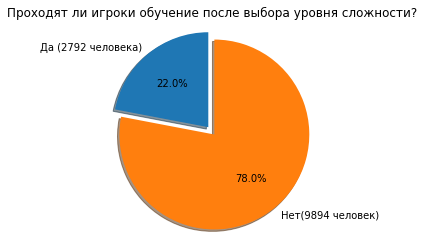

In [24]:
#Представим полученные результаты в виде круговой диаграммы
labels = 'Да (2792 человека)', 'Нет(9894 человек)'
sizes = [22, 78]
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title("Проходят ли игроки обучение после выбора уровня сложности?")
plt.show()

**Вывод №3:**

Из результатов анализа видно, что примерно **в одном случае из пяти игрок (22%)** проходит обучение после выбора уровня сложности и начала игры. Значит, для них процесс взаимодействия с игрой ясен не до конца.

### Рекомендации  

Таким образом, можно сказать, что прохождение  обучения как улучшает пользовательский опыт взаимодесйствия с приложением, так и способсвует тому, чтобы игроки совершали покупки. Поэтому представляется целесообразным сделать следующее:
- Сделать пропуск обучения сложнее для игроков, возможно, превратить его в обязаельный этап взаимодействия с игрой;
- Пересмотреть содержание обучения и сделать его более понятным, чтобы снизить количество его повторных прохождений одним и тем же игроком.